In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jul 14 18:59:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras==2.3.1

     |████████████████████████████████| 378kB 8.3MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
# import tensorflow.keras as keras
import numpy as np
import os
import random

! pip install keras-tuner
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPool1D, LSTM, MaxPool1D
from tensorflow.keras.layers import ReLU, BatchNormalization, Bidirectional, concatenate, Reshape, TimeDistributed
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPool2D, SpatialDropout2D, Softmax, ELU, Layer, Masking
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D, LeakyReLU, LSTMCell, RNN, InputSpec
from tensorflow.keras.layers import concatenate, Conv1DTranspose, Conv2DTranspose, Flatten, StackedRNNCells
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow import keras as keras
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib import pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Permute, multiply, Activation
import tensorflow.keras.backend as K

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints


     |████████████████████████████████| 102kB 6.4MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=7d2c189b17d55ae56d6b230961e62dbc2d697dadb5d2ba3fac956247259091f3
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


def weight_variable(shape):
    initial = tf.random.truncated_normal(shape, std_dev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

batch_size = 512
num_classes = 745

In [ ]:
X_train.shape, train_label.shape, X_test.shape, test_label.shape

((13212, 6, 128), (13212, 745), (1409, 6, 128), (1409, 745))

In [ ]:
def tuned_lstm_model(hp):
    # model = Sequential()
    input_seq = Input(shape=(6, 128))
    processed = LSTM(hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(6, 128))(input_seq)
    processed = Dropout(0.5)(processed)
    # x = (Dense(118*8, activation='relu'))(processed)
    # x = (Dense(118*4, activation='relu'))(x)
    processed =ReLU()(processed)
    activated = (Dense(745, activation='softmax'))(processed)
    model = Model(inputs=input_seq, outputs=activated)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    tuned_lstm_model,
    objective='val_accuracy',
    max_trials=10,
    directory='output_ou_isir',
    project_name='TIFS20')

tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[EarlyStopping(monitor='val_loss', patience=30)])

Trial 10 Complete [00h 01m 22s]
val_accuracy: 0.5007564425468445

Best val_accuracy So Far: 0.5030257105827332
Total elapsed time: 00h 25m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 128)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 480)               1169280   
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
re_lu (ReLU)                 (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 745)               358345    
Total params: 1,527,625
Trainable params: 1,527,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=[EarlyStopping('val_loss', patience=30)])#, callbacks=[es_callback])

Epoch 1/100
24/24 [==============================] - 2s 31ms/step - loss: 0.0432 - accuracy: 0.9976 - val_loss: 2.4317 - val_accuracy: 0.4992
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0375 - accuracy: 0.9974 - val_loss: 2.4252 - val_accuracy: 0.4985
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0354 - accuracy: 0.9978 - val_loss: 2.4225 - val_accuracy: 0.5015
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0344 - accuracy: 0.9983 - val_loss: 2.4165 - val_accuracy: 0.5068
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0342 - accuracy: 0.9987 - val_loss: 2.4179 - val_accuracy: 0.5061
Epoch 6/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0331 - accuracy: 0.9972 - val_loss: 2.4172 - val_accuracy: 0.4985
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0314 - accuracy: 0.9986 - val_loss: 2.4155 - val_accuracy: 0.4970
Epoch 

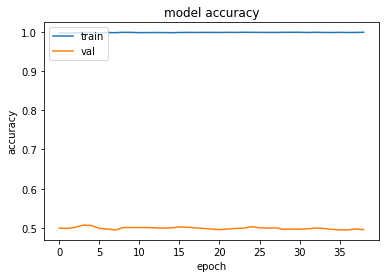

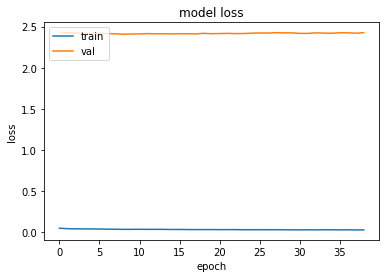

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.0720043182373047
Test accuracy: 0.4449964463710785


In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/tuned_lstm_87.h5')

In [ ]:
# Test loss: 2.6829161643981934
# Test accuracy: 0.4144783616065979